In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
%matplotlib inline
%load_ext autoreload
%load_ext jupyterlab_notify
%autoreload 2

# MINST Dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
type(X)

pandas.core.frame.DataFrame

5


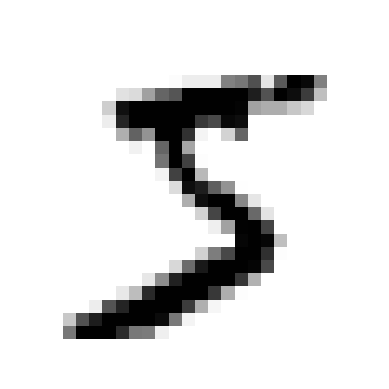

In [6]:
some_digit = X.iloc[0].values.reshape(28, -1)
plt.imshow(some_digit, cmap="binary")
plt.axis("off")
print(y[0])

In [7]:
type(y)

pandas.core.series.Series

In [8]:
# y => is categories list
# let's convert it to numbers
y = y.astype(np.uint8)
# MINST Is already splitted into train (6000), test
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# Preprocessing

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

# Excerise 1

<div style="background-color:#3871b2;color:#FFF;font-size:18px;padding:20px;width:60%;border-radius:20px"> Try to build a classifier for the MNIST dataset that achieves over
97% accuracy on the test set. Hint: the KNeighborsClassifier
works quite well for this task; you just need to find good
hyperparameter values (try a grid search on the weights and
n_neighbors hyperparamete</div>rs).

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, precision_score, precision_recall_curve, recall_score, roc_auc_score, roc_curve, accuracy_score

In [12]:
knn_clf = KNeighborsClassifier().fit(X_train, y_train)
base_line_accuracy = accuracy_score(y_test, knn_clf.predict(X_test))
base_line_accuracy

0.9688

In [13]:
knn_clf = KNeighborsClassifier().fit(X_train_scaled, y_train)
base_line_accuracy = accuracy_score(y_test, knn_clf.predict(X_test_scaled))
base_line_accuracy

0.9443

In [14]:
# it's better to use non scaled version

In [15]:
parameters = {
    'n_neighbors': [1, 2, 4, 6, 8, 10, 15, 20, 30],
    'weights': ['uniform', 'distance']
}

In [16]:
knn_clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring="accuracy", cv=3)

In [20]:
%%notify
knn_clf.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 4, 6, 8, 10, 15, 20, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

<Axes: >

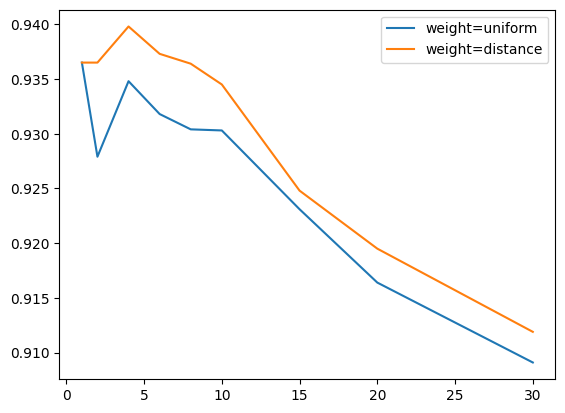

In [21]:
knn_cv_res_uniform = knn_clf.cv_results_['mean_test_score'][::2]
knn_cv_res_distance = knn_clf.cv_results_['mean_test_score'][1::2]

sns.lineplot(x=parameters['n_neighbors'], y=knn_cv_res_uniform, label='weight=uniform')
sns.lineplot(x=parameters['n_neighbors'], y=knn_cv_res_distance, label='weight=distance')


In [22]:
knn_clf.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [23]:
knn_clf.best_score_

0.9397994088551026

In [26]:
knn_clf.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [27]:
tunned_acc = accuracy_score(y_test, knn_clf.best_estimator_.predict(X_test))
tunned_acc

0.9714

# Excersie 2

<div style="background-color:#3871b2;color:#FFF;font-size:18px;padding:20px;width:60%;border-radius:20px">
    Write a function that can shift an MNIST image in any direction    
(left, right, up, or down) by one pixel. Then, for each image in    
the training set, create four shifted copies (one per direction) an    d
add them to the training set. Finally, train your best model on th    is
expanded training set and measure its accuracy on the test s    et.
You should observe that your model performs even better     now!
This technique of artificially growing the training set is c    alled
data augmentation or training set exp
</div>ansion.

In [28]:
from scipy.ndimage import shift

In [67]:
def custom_shift_row(row, dx, dy):
    img = row.reshape(28, 28)
    img_shifted = shift(img, (dx, dy))
    return img_shifted.reshape(-1, )
    
X_train_augmented = X_train.values.copy()
X_train_augmented_b = np.apply_along_axis(lambda x: custom_shift_row(x, 1, 0), axis=1, arr=X_train_augmented)
X_train_augmented_t = np.apply_along_axis(lambda x: custom_shift_row(x, -1, 0), axis=1, arr=X_train_augmented)
X_train_augmented_l = np.apply_along_axis(lambda x: custom_shift_row(x, 0, -1), axis=1, arr=X_train_augmented)
X_train_augmented_r = np.apply_along_axis(lambda x: custom_shift_row(x, 0, 1), axis=1, arr=X_train_augmented)

(-0.5, 27.5, 27.5, -0.5)

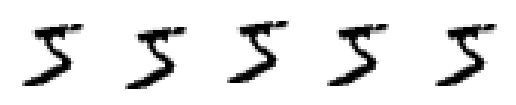

In [68]:
plt.subplot(151)
plt.imshow(X_train_augmented[0,:].reshape(28,28), cmap='binary') 
plt.axis("off")
plt.subplot(152)
plt.imshow(X_train_augmented_b[0,:].reshape(28,28), cmap='binary') 
plt.axis("off")
plt.subplot(153)
plt.imshow(X_train_augmented_t[0,:].reshape(28,28), cmap='binary') 
plt.axis("off")
plt.subplot(154)
plt.imshow(X_train_augmented_l[0,:].reshape(28,28), cmap='binary') 
plt.axis("off")
plt.subplot(155)
plt.imshow(X_train_augmented_r[0,:].reshape(28,28), cmap='binary') 
plt.axis("off")

In [69]:
X_train_augmented = np.r_[X_train_augmented, X_train_augmented_b, X_train_augmented_t, X_train_augmented_l, X_train_augmented_r]

In [70]:
y_train_augmented = np.r_[y_train, y_train, y_train, y_train, y_train]
X_train_augmented.shape, y_train_augmented.shape

((300000, 784), (300000,))

In [71]:
knn_clf.best_estimator_.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [72]:
augmented_acc = accuracy_score(y_test, knn_clf.best_estimator_.predict(X_test))
augmented_acc

C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.9763

In [73]:
error_rate_change = (1 - augmented_acc) / (1 - tunned_acc) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%
